In [1]:
import pandas as pd
import pickle
import numpy as np
import string
import operator
import re
import os
import sys
import codecs
from collections import Counter
import csv
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 7})
import pandas as pd

import seaborn as sns

import wordcloud
from wordcloud import WordCloud

import nltk
from nltk import ngrams
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import FreqDist
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec
from gensim import models, corpora
from gensim.models import TfidfModel

import sklearn
from sklearn.decomposition import PCA
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

## Preparation

In [2]:
spam_ham = pd.read_csv("../../NLPINTROLIVE-master/NLPINTROLIVE-master/SMSSpamCollection.csv",  encoding='iso-8859-1')
spam_ham['Length'] = spam_ham.Description.str.len()
spam_ham.head()

,Email,Description,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [3]:
spam_ham.groupby('Email').Length.mean()

Email
ham      71.450590
spam    138.670683
Name: Length, dtype: float64

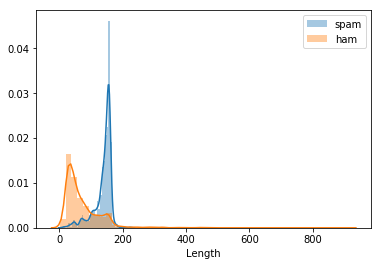

In [4]:
sns.distplot(spam_ham[spam_ham.Email=='spam'].Length, label='spam')
sns.distplot(spam_ham[spam_ham.Email=='ham'].Length, label='ham')
plt.legend()

In [5]:
def clean_up_text(text):
    tokens = split_text_to_tokens(text)
    tokens = clean_up_tokens(tokens)
    processed_text = " ".join(tokens)
    return processed_text

def split_text_to_tokens(text):
    return nltk.word_tokenize(text)

def clean_up_tokens(tokens):
    tokens = remove_punctuation_from_tokens(tokens)
    tokens = remove_non_alphabetic_tokens(tokens)
    tokens = set_tokens_to_lowercase(tokens)
    tokens = remove_stopwords_from_tokens(tokens)
    tokens = remove_small_words_from_tokens(tokens)
    tokens = lemmatize_tokens(tokens)
    tokens = remove_unimportant_words_from_tokens(tokens)
    return tokens

def remove_punctuation_from_tokens(tokens):
    translation_table = str.maketrans({key: None for key in string.punctuation})
    text_without_punctuations = []
    for each_token in tokens:
        text_without_punctuations.append(each_token.translate(translation_table))
    return text_without_punctuations

def remove_non_alphabetic_tokens(tokens):
    alphabetic_tokens = []
    for token in tokens:
        if token.isalpha():
            alphabetic_tokens.append(token)
    return alphabetic_tokens

def set_tokens_to_lowercase(tokens):
    lowercase_tokens = []
    return [each_token.lower() for each_token in tokens]

def remove_stopwords_from_tokens(tokens):
    stop_words = set(stopwords.words("english"))
    return [each_token for each_token in tokens if each_token not in stop_words]

def remove_small_words_from_tokens(tokens):
    return [each_token for each_token in tokens if len(each_token) > 2]

def remove_unimportant_words_from_tokens(tokens):
    lemmatized_tokens = lemmatize_tokens(tokens)
    tokens_with_part_of_speech_tags = nltk.pos_tag(lemmatized_tokens)
    cleared_token_list = [each_token[0] for each_token in tokens_with_part_of_speech_tags if each_token[1] in ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]]
    # JJ (adjective), NN (noun), NNP (proper noun), RB (adverb), VB (verb) 
    return cleared_token_list

def lemmatize_tokens(tokens):
    wordnet_lemmatizer = WordNetLemmatizer()
    parts_of_speech = [wordnet.ADJ, wordnet.ADJ_SAT, wordnet.ADV, wordnet.NOUN, wordnet.VERB]
    lemmatized_tokens = tokens
    for each_part_of_speech in parts_of_speech:
        lemmatized_tokens = [wordnet_lemmatizer.lemmatize(each_token, pos=each_part_of_speech) for each_token in lemmatized_tokens]
    return lemmatized_tokens

def preprocess(pstr1):
     s=split_text_to_tokens(pstr1)
     s=remove_non_alphabetic_tokens(s)
     s=remove_punctuation_from_tokens(s)
     s=set_tokens_to_lowercase(s)
     return s

In [6]:
spam_ham.Description = spam_ham.Description.apply(clean_up_text)
spam_ham.head()

,Email,Description,Length
0,ham,jurong point crazy available bugis great world...,111
1,ham,lar joke wif oni,29
2,spam,free entry wkly comp win cup final tkts text r...,155
3,ham,dun say early hor already say,49
4,ham,nah think go usf life,61


In [7]:
vectorizer = TfidfVectorizer()
vectorised = vectorizer.fit_transform(spam_ham.Description)
tdm = pd.DataFrame(vectorised.toarray(), columns = vectorizer.get_feature_names())
tdm.head()

,aah,aaniye,aaooooright,aathilove,aathiwhere,abbey,abdomen,abeg,abel,aberdeen,...,zaher,zealand,zed,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print('Length of the spam_ham dataset: ',len(spam_ham))
cutoff = 5000
print('Cutoff for train/test: ', cutoff)

Length of the spam_ham dataset:  5574
Cutoff for train/test:  5000


In [9]:
spam_ham['Ham'] = (spam_ham.Email=='ham').apply(int)
spam_ham.head()

,Email,Description,Length,Ham
0,ham,jurong point crazy available bugis great world...,111,1
1,ham,lar joke wif oni,29,1
2,spam,free entry wkly comp win cup final tkts text r...,155,0
3,ham,dun say early hor already say,49,1
4,ham,nah think go usf life,61,1


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(tdm[:cutoff], spam_ham.Ham[:cutoff])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
y_pred = list(clf.predict(tdm[cutoff:]))
y_pred[-10:]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

In [12]:
y_true = list(spam_ham.Ham[cutoff:])
y_true[-10:]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

In [13]:
count = 0 
for i in range(len(y_pred)):
    if y_pred[i]==y_true[i]:
        count += 1
print("Accuracy with a RF: ", count/len(y_pred))

Accuracy with a RF:  0.9773519163763066


## Support Vector Machine

In [14]:
from sklearn import svm
clf = svm.SVC()
clf.fit(tdm[:cutoff], spam_ham.Ham[:cutoff])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [15]:
y_pred = list(clf.predict(tdm[cutoff:]))
y_pred[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [16]:
y_true = list(spam_ham.Ham[cutoff:])
y_true[-10:]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

In [17]:
count = 0 
for i in range(len(y_pred)):
    if y_pred[i]==y_true[i]:
        count += 1
print("Accuracy with a SVM: ", count/len(y_pred))

Accuracy with a SVM:  0.8710801393728222


## Multi-layer Perceptron

In [18]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(tdm[:cutoff], spam_ham.Ham[:cutoff])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [19]:
y_pred = list(clf.predict(tdm[cutoff:]))
y_pred[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
y_true = list(spam_ham.Ham[cutoff:])
y_true[-10:]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

In [21]:
count = 0 
for i in range(len(y_pred)):
    if y_pred[i]==y_true[i]:
        count += 1
print("Accuracy with a MLP: ", count/len(y_pred))

Accuracy with a MLP:  0.8710801393728222
